In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget

In [6]:
L = 0.65 #longueur de corde (m)
f1 = 110 #freq de la corde (hz)
T = 73.9 #tension de la corde (N)
rho_l = 3.61 * 10**(-3) #masse linéique (kg/m)
ct = np.sqrt(T/rho_l) #célérité des ondes transverse (M/s)
B = 4*10**(-5) #coefficient d'inarmonicité : B = E*I (N*m**2)

In [42]:
Nm = 100 #nombre de mode
Nn = np.arange(1,Nm+1)
pn = (2 * Nn - 1) * np.pi / (2 * L)
fn = (ct / (2 * np.pi)) * pn * (1 + pn**2 * B / (2 * T)) #fréquence modale inharmonique
wn = 2 * np.pi * fn

Nx = 1000 #discrétisation de la corde
x = np.linspace(0,L,Nx)
phi_Nx_Nm = np.sin((2*Nn[np.newaxis,:]-1)*np.pi*x[:,np.newaxis]/2/L) #mode de la corde

In [43]:
Mm = rho_l * L / 2  #masse modale corde

etaf, etaA, etaB = 7e-5, 0.9, 2.5e-2 #coefficient de perte
xin = 1 / 2 * ( T * (etaf + etaA/ 2 / np.pi / fn) + etaB * B * pn**2 ) / (T + B * pn**2) #amortissement modale

In [56]:
deltat = 1e-5 #pas de discrétisation : s
tfin = 10 #temps final d'intégration

xinB = np.array([2.2,1.1,1.6,1.0,0.7,0.9,1.1,0.7,1.4,0.9,0.7,0.7,0.6,1.4,1.0,1.3])/100
fnB = np.array([78.3,100.2,187.3, 207.8, 250.9,291.8,314.7,344.5,399.0,429.6,482.9,504.2,553.9,580.3,645.7,723.5])
mnB = np.array([2.91,0.45,0.09,0.25,2.65,9.88,8.75,8.80,0.90,0.41,0.38,1.07,2.33,1.36,2.02,0.45])
NnB = np.arange(1,17)

NmB = len(fnB)
wnB = 2*np.pi*fnB

MB = np.diag(mnB)
CB = np.diag(2*mnB*wnB*xinB)
KB = np.diag(mnB*wnB**2)

In [45]:
MS = np.diag(np.array([Mm]*Nm))
CS = MS * np.diag(2*wn*xin)
KS = MS*np.diag(wn**2)

In [92]:
#Matrices concaténées par block
M = np.block([
              [MS               , np.zeros((Nm,NmB))],
              [np.zeros((NmB,Nm)), MB               ]
])

K = np.block([
              [KS               , np.zeros((Nm,NmB))],
              [np.zeros((NmB,Nm)), KB               ]
])

C = np.block([
              [CS               , np.zeros((Nm,NmB))],
              [np.zeros((NmB,Nm)), CB               ]
])

In [61]:
#On dit dans un premier temps que la corde est attachée à gauche et à droite (on appuie pas dessus)

phiSB = phi_Nx_Nm[-1,:] #dernier indice en x => x=L
phiSF = phi_Nx_Nm[1,:] #premier indice en x : x=0

Aa1 = np.block([
                [phiSB.T, np.zeros(NmB)],
                [phiSF.T, np.zeros(NmB)]
])

B = Aa1 @ np.linalg.inv(M**(1/2))

Bplus = B.T @ np.linalg.inv((B @ B.T))

W = 1 - np.linalg.inv(M**(1/2)) @ Bplus @ Aa1

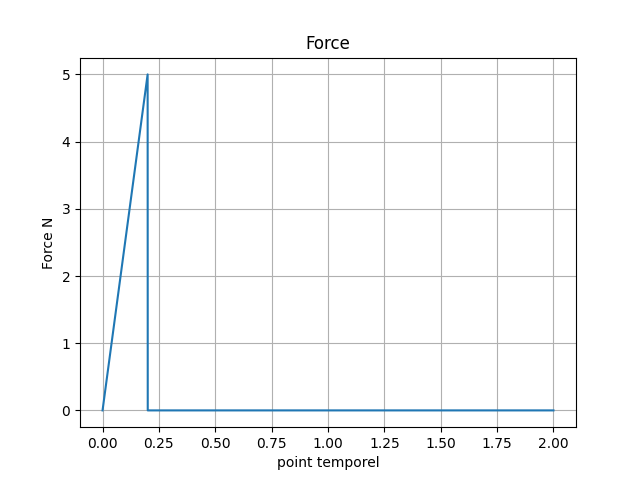

In [159]:
t_fin = 2
point_temp = 44100 * t_fin
vec_temp = np.linspace(0,t_fin, point_temp)
## déf de la force : 
F = np.zeros(point_temp)
idx_deb = 0
idx_fin = point_temp//10
F[idx_deb:idx_fin] = np.linspace(0,1,idx_fin - idx_deb) * 5
plt.figure()
plt.plot(vec_temp,F)
plt.title("Force")
plt.grid()
plt.ylabel('Force N')
plt.xlabel('point temporel')
plt.show()

In [160]:
idx_applique_F = int(0.9 * Nx)
F_mat = np.zeros((Nx,point_temp))
F_mat[idx_applique_F,:] = F
F_pro_cor = phi_Nx_Nm.T @ F_mat


In [161]:
F_pro_tot = np.zeros((Nm+NmB,point_temp)) #comme il n'y a pas de force sur la table, sa base modale vaut 0
F_pro_tot[:Nm,:] = F_pro_cor

In [173]:
#initialisation du shéma numérique de résolution
q_temp = np.zeros((Nm + NmB, point_temp))
q_u_dd_temp = np.zeros_like(q_temp)
q_d_temp = np.zeros((Nm + NmB, point_temp))
q_d_temp_demi = np.zeros((Nm + NmB, point_temp))
q_dd_temp = np.zeros((Nm + NmB, point_temp))
h = 0.05 #step d'intégration
F_temp = np.zeros_like(F_pro_tot)

In [174]:
#shéma
for i in range(100):#point_temp-1):
    q_temp[:,i+1] = q_temp[:,i] + h * q_d_temp[:,i] + 0.5 * h**2 * q_dd_temp[:,i]
    q_d_temp_demi[:,i+1] = q_d_temp[:,i] + 0.5 * h * q_dd_temp[:,i]

    F_temp[:,i+1] = - C @ q_d_temp_demi[:,i+1] - K @ q_temp[:,i+1] + F_pro_tot[:,i+1]
    q_u_dd_temp[:,i+1] = np.linalg.inv(M) @ F_temp[:,i+1]
    print(np.where(q_u_dd_temp == np.nan))

    q_dd_temp[:,i+1] = W @ q_u_dd_temp[:,i+1]

    q_d_temp[:,i+1] = q_d_temp[:,i] + 0.5 * h * (q_dd_temp[:,i] + q_dd_temp[:,i+1])

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int

/var/folders/k2/m05vfpwn0qn71pjn0jnlb0l80000gn/T/ipykernel_38441/443464532.py:10: RuntimeWarning: overflow encountered in matmul
  q_dd_temp[:,i+1] = W @ q_u_dd_temp[:,i+1]
/var/folders/k2/m05vfpwn0qn71pjn0jnlb0l80000gn/T/ipykernel_38441/443464532.py:6: RuntimeWarning: invalid value encountered in matmul
  F_temp[:,i+1] = - C @ q_d_temp_demi[:,i+1] - K @ q_temp[:,i+1] + F_pro_tot[:,i+1]


(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int

In [166]:
np.linalg.inv(M) @ F_temp[:,i+1]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])